# Exogenous Variables

Exogenous variables or external factors are crucial in time series forecasting as they provide additional information that might influence the prediction. These variables could include holiday markers, marketing spending, weather data, or any other external data that correlate with the time series data you are forecasting.

For example, if you're forecasting ice cream sales, temperature data could serve as a useful exogenous variable. On hotter days, ice cream sales may increase.

To incorporate exogenous variables in TimeGPT, you'll need to pair each point in your time series data with the corresponding external data.

In [2]:
# | hide
from dotenv import load_dotenv

In [3]:
# | hide
load_dotenv()

True

In [4]:
import pandas as pd
from nixtlats import TimeGPT
import os

In [5]:
timegpt = TimeGPT(token=os.getenv("TIMEGPT_TOKEN"))

In [6]:
# | hide
timegpt = TimeGPT()

You can test the validate of your token calling the `validate_token` method:

In [9]:
timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

Let's see an example on predicting day-ahead electricity prices. The following dataset contains the hourly electricity price (`y` column) for five markets in Europe and US, identified by the `unique_id` column. The columns from `Exogenous1` to `day_6` are exogenous variables that TimeGPT will use to predict the prices.

In [10]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv"
)
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-01 00:00:00,72.00,61507.0,71066.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,BE,2016-12-01 01:00:00,65.80,59528.0,67311.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,BE,2016-12-01 02:00:00,59.99,58812.0,67470.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,BE,2016-12-01 03:00:00,50.69,57676.0,64529.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,BE,2016-12-01 04:00:00,52.58,56804.0,62773.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


To produce forecasts we also have to add the future values of the exogenous variables. Let's read this dataset. In this case, we want to predict 24 steps ahead, therefore each `unique_id` will have 24 observations.

In [11]:
future_ex_vars_df = pd.read_csv(
    "https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-future-ex-vars.csv"
)
future_ex_vars_df.head()

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,64108.0,70318.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-12-31 01:00:00,62492.0,67898.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-12-31 02:00:00,61571.0,68379.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-12-31 03:00:00,60381.0,64972.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-12-31 04:00:00,60298.0,62900.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Let's call the `forecast` method, adding this information:

In [12]:
timegpt_fcst_ex_vars_df = timegpt.forecast(
    df=df, X_df=future_ex_vars_df, h=24, level=[80, 90]
)
timegpt_fcst_ex_vars_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: h
INFO:nixtlats.timegpt:Attempt 1 failed...
INFO:nixtlats.timegpt:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,BE,2016-12-31 00:00:00,48.235492,38.564627,43.525878,52.945107,57.906358
1,BE,2016-12-31 01:00:00,45.188141,33.659668,36.171925,54.204357,56.716614
2,BE,2016-12-31 02:00:00,48.867367,36.208286,39.510485,58.224250,61.526448
3,BE,2016-12-31 03:00:00,39.980112,24.760213,27.955178,52.005046,55.200011
4,BE,2016-12-31 04:00:00,38.964503,22.335701,27.180510,50.748496,55.593304


> BEFORE: *4 API Calls | 253200 Tokens | 443.04 Spent*  
> AFTER: *5 API Calls | 290880 Tokens | 489.46 Spent*  
> **USAGE: 1 API Call | 37680 Tokens | 46.42 Spent**

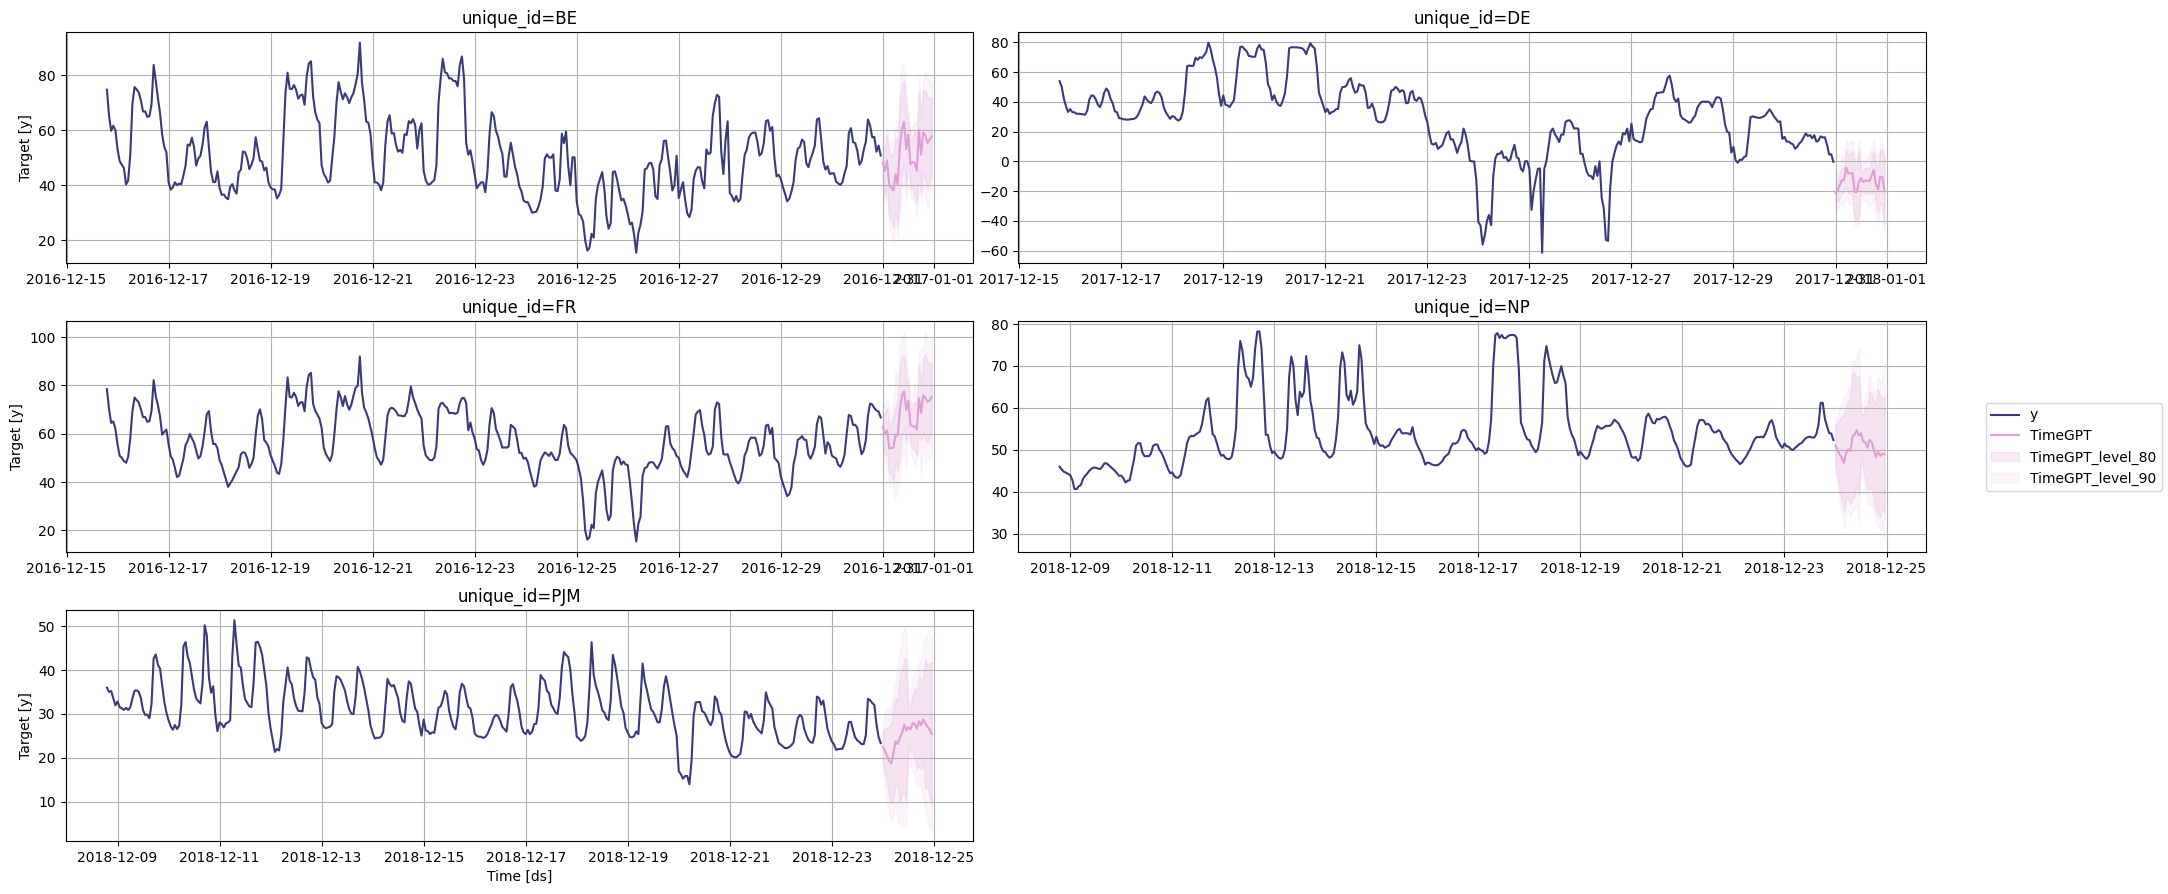

In [13]:
timegpt.plot(
    df[["unique_id", "ds", "y"]],
    timegpt_fcst_ex_vars_df,
    max_insample_length=365,
    level=[80, 90],
)

We also can get the importance of the features.

<Axes: ylabel='features'>

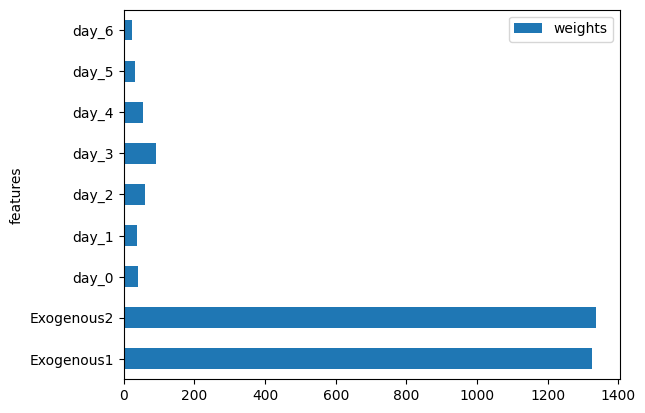

In [14]:
timegpt.weights_x.plot.barh(x="features", y="weights")

You can also add country holidays using the `CountryHolidays` class.

In [15]:
from nixtlats.date_features import CountryHolidays

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: h
INFO:nixtlats.timegpt:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6, US_New Year's Day, US_Memorial Day, US_Independence Day, US_Labor Day, US_Veterans Day, US_Thanksgiving, US_Christmas Day, US_Christmas Day (observed), US_Martin Luther King Jr. Day, US_Washington's Birthday, US_Columbus Day, US_New Year's Day (observed), US_Veterans Day (observed)
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


<Axes: ylabel='features'>

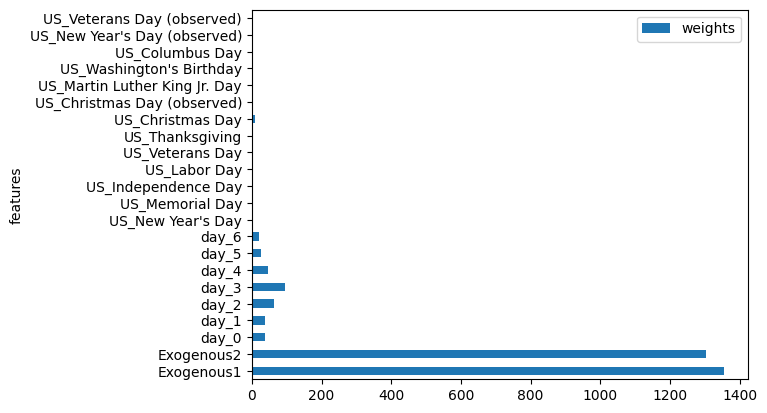

In [16]:
timegpt_fcst_ex_vars_df = timegpt.forecast(
    df=df,
    X_df=future_ex_vars_df,
    h=24,
    level=[80, 90],
    date_features=[CountryHolidays(["US"])],
)
timegpt.weights_x.plot.barh(x="features", y="weights")

> BEFORE: *5 API Calls | 290880 Tokens | 489.46 Spent*  
> AFTER: *6 API Calls | 376920 Tokens | 593.91 Spent*  
> **USAGE: 1 API Call | 86040 Tokens | 104.45 Spent**